#### 25 Desember 2022
# Image Classification
### Kelompok 4
1. Ardyn Rezky Fahreza (2103551)
2. Muhammad Fikri Kafilli (2107264)
3. Bayu Wicaksono (2106836)
4. Muhammad Fadlan Ghafur (2106923)
5. Talitha Syahla (2101330)

Dataset untuk klasifikasi gambar yang digunakan oleh Kelompok 4 adalah klasifikasi mengenai gambar cuaca, seperti cuaca cerah, cuaca hujan, dll. Dataset yang kami gunakan berasal dari [link berikut](https://www.kaggle.com/datasets/ammaralfaifi/5class-weather-status-image-classification). 

In [ ]:
# import library
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd
 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

In [ ]:
# download dataset dan unzip dataset
import zipfile, os
import shutil
import pathlib
local_zip = '/content/data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/data2')
zip_ref.close()
# menentukan path dari folder dataset
base_dir = '/content/data2/content/data'
!rm -rf '/content/data2/content/data/cloudy'
data_dir = pathlib.Path(base_dir)

In [ ]:
# menghitung total dataset image yang ada di folder
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

5378


In [ ]:
# melihat jumlah class dan jumlah gambar tiap class
import os
list_dir = [os.path.basename(x) for x in data_dir.iterdir() if x.is_dir()]
print("Jumlah class: {} ".format(len(list_dir)))
print("Jumlah instance per class")
for x in list_dir:
 print("{} = {} ".format(x,len(list(data_dir.glob('{}/*.jpg'.format(x))))))

Jumlah class: 4 
Jumlah instance per class
sunny = 1224 
snowy = 1566 
rainy = 1591 
foggy = 997 


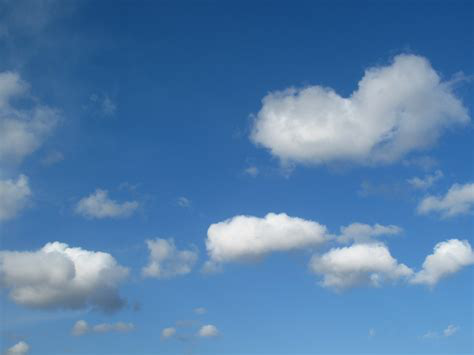

In [ ]:
# melihat salah satu contoh gambar
cloudy = list(data_dir.glob('sunny/*'))
PIL.Image.open(str(cloudy[1032]))

#### Mengatur ukuran batch, panjang dan lebar gambar agar ukuran semua gambarnya sama

In [ ]:
batch_size = 32
img_height = 200
img_width = 200

#### Membagi dataset menjadi training data, validation data, dan testing data dengan rasio (80%, 10%, 10%)

In [ ]:
%pip install split-folders
import splitfolders
splitfolders.ratio(data_dir, output="/content/splitdataset", seed=123, ratio=(.8, .1, .1), group_prefix=None) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 6234 files [00:02, 2682.36 files/s]


### Mempersiapkan data training, data validation, dan data test

In [ ]:
# melihat jumlah image per class untuk training data
base_train_dir = "/content/splitdataset/train"
train_dir = pathlib.Path(base_train_dir)
list_dir = [os.path.basename(x) for x in train_dir.iterdir() if x.is_dir()]
print("Jumlah class: {} ".format(len(list_dir)))
print("Jumlah instance per class")
for x in list_dir:
 print("{} = {} ".format(x,len(list(train_dir.glob('{}/*.jpg'.format(x))))))

# menyiapkan dataset training
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Jumlah class: 4 
Jumlah instance per class
sunny = 982 
snowy = 1263 
rainy = 1283 
foggy = 811 
Found 4985 files belonging to 4 classes.


In [ ]:
# melihat jumlah image per class untuk validation data
base_val_dir = "/content/splitdataset/val"
val_dir = pathlib.Path(base_val_dir)
list_dir = [os.path.basename(x) for x in val_dir.iterdir() if x.is_dir()]
print("Jumlah class: {} ".format(len(list_dir)))
print("Jumlah instance per class")
for x in list_dir:
  print("{} = {}".format(x,len(list(val_dir.glob('{}/*.jpg'.format(x))))))

# menyiapkan dataset validation
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Jumlah class: 4 
Jumlah instance per class
sunny = 118
snowy = 151
rainy = 153
foggy = 90
Found 621 files belonging to 4 classes.


In [ ]:
# melihat jumlah image per class untuk testing data
base_test_dir = "/content/splitdataset/test"
test_dir = pathlib.Path(base_test_dir)
list_dir = [os.path.basename(x) for x in test_dir.iterdir() if x.is_dir()]
print("Jumlah class: {} ".format(len(list_dir)))
print("Jumlah instance per class")
for x in list_dir:
  print("{} = {}".format(x,len(list(test_dir.glob('{}/*.jpg'.format(x))))))

# menyiapkan dataset testing
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Jumlah class: 4 
Jumlah instance per class
sunny = 124
snowy = 152
rainy = 155
foggy = 96
Found 628 files belonging to 4 classes.


#### Menampilkan nama class yang tersedia

In [ ]:
class_names = train_ds.class_names
print(class_names)

['foggy', 'rainy', 'snowy', 'sunny']


#### Menampilkan preview dataset training

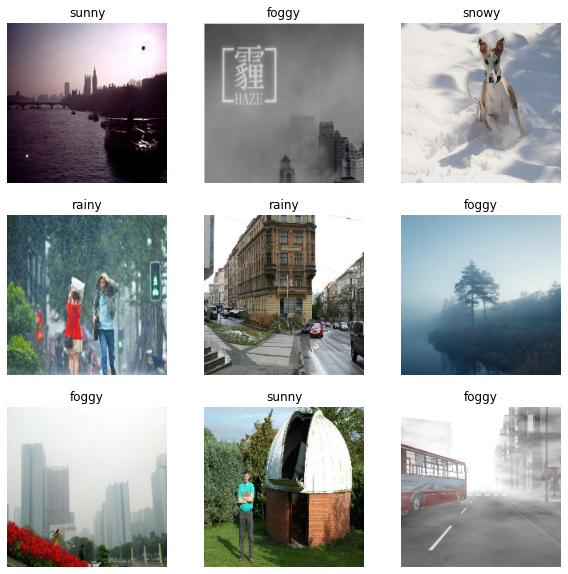

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
 for i in range(9):
   ax = plt.subplot(3, 3, i + 1)
   plt.imshow(images[i].numpy().astype("uint8"))
   plt.title(class_names[labels[i]])
   plt.axis("off")

#### Menampilkan shape untuk data training

In [ ]:
for image_batch, labels_batch in train_ds:
 print(image_batch.shape)
 print(labels_batch.shape)
 break

(32, 200, 200, 3)
(32,)


###  Set cache buffer untuk data training dan validation

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Normalisasi nilai RGB

In [ ]:
# normalisasi nilai RGB menggunakan layer rescaling
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# nilai dari [0 sd 255] menjadi [0 sd 1]
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Proses pembuatan arsitektur deep learning. 
#### Pada percobaan kali ini, kami menggunakan **3 layer Conv2D** dengan ukuran filter 3 x 3 dan menggunakan activation function **ReLU**

In [ ]:
num_classes = len(class_names) 
model = Sequential([
 layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
 layers.Conv2D(16, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Conv2D(32, 3, padding='same'8, activation='relu'),
 layers.MaxPooling2D(),
 layers.Conv2D(64, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Flatten(),
 layers.Dense(128, activation='relu'),
 layers.Dense(num_classes)
 ])

#### Arsitektur akan di-compile dan optimizer yang digunakan untuk proses train adalah **Adam**

In [ ]:
model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

#### Melihat ringkasan arsitektur

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        1

#### Percobaan pertama dalam proses train sebanyak **5 epoch**

In [ ]:
epochs=5
history = model.fit(
 train_ds,
 validation_data=val_ds,
 epochs=epochs
)

Epoch 1/5
156/156 [==============================] - 11s 38ms/step - loss: 0.9134 - accuracy: 0.6193 - val_loss: 0.7069 - val_accuracy: 0.7101
Epoch 2/5
156/156 [==============================] - 4s 29ms/step - loss: 0.6136 - accuracy: 0.7631 - val_loss: 0.6329 - val_accuracy: 0.7729
Epoch 3/5
156/156 [==============================] - 4s 29ms/step - loss: 0.5233 - accuracy: 0.8096 - val_loss: 0.5516 - val_accuracy: 0.7971
Epoch 4/5
156/156 [==============================] - 5s 29ms/step - loss: 0.3773 - accuracy: 0.8634 - val_loss: 0.7193 - val_accuracy: 0.7504
Epoch 5/5
156/156 [==============================] - 4s 29ms/step - loss: 0.2770 - accuracy: 0.8993 - val_loss: 0.7220 - val_accuracy: 0.7746


Dapat terlihat bahwa pada Epoch ke 5, didapatkan **akurasi** untuk **data training** sebesar **0.8993** dengan **loss 0.2770** dan **akurasi** untuk **data validation** sebesar **0.7746** dengan **loss 0.7220**.


---


#### Membuat plot untuk melihat hasil kinerja data training dan data validation untuk percobaan pertama

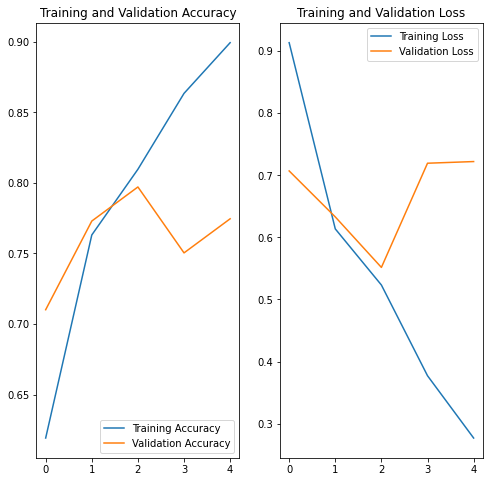

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Dapat terlihat pada plot bahwa kinerja data training sudah bagus, namun untuk data validation masih buruk. Ini menandakan adanya **overfitting**. Overvitting adalah kondisi dimana model hanya bagus untuk data training.


---

#### Dalam menangani overvitting pada deep learning, salah satu caranya adalah menggunakan **augmentasi data training**.

In [ ]:
# proses augmentasi data training
data_augmentation = keras.Sequential(
     [
   layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                 3)),
   layers.RandomRotation(0.1),
   layers.RandomZoom(0.1),
 ]
)


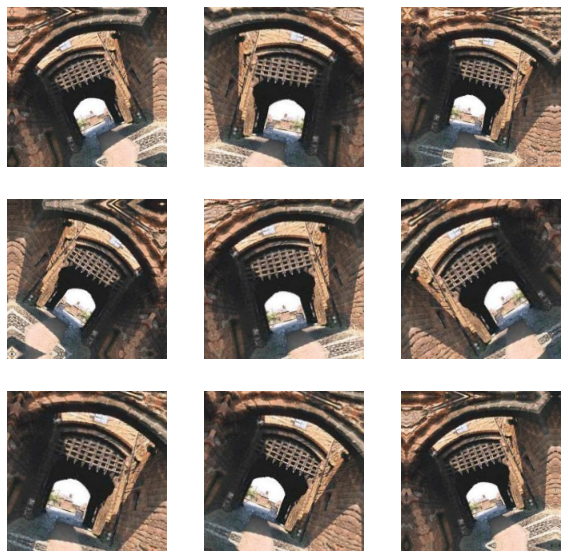

In [ ]:
# menampilkan gambarnya
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
 for i in range(9):
   augmented_images = data_augmentation(images)
   ax = plt.subplot(3, 3, i + 1)
   plt.imshow(augmented_images[0].numpy().astype("uint8"))
   plt.axis("off")

#### Percobaan kedua untuk membuat arsitektur, kami menambahkan 1 layer Conv2D menjadi **4 layer Conv2D** dan **Dropout** dengan ukuran filter, serta jenis fungsi aktivasi yang sama

In [ ]:
model = Sequential([
 data_augmentation,
 layers.Rescaling(1./255),
 layers.Conv2D(16, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Conv2D(32, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Conv2D(64, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Conv2D(128, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Dropout(0.2),
 layers.Flatten(),
 layers.Dense(256, activation='relu'),
 layers.Dense(num_classes, name="outputs")
])

#### Compile model dengan optimizer yang sama

In [ ]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

#### Pada percobaan kedua ini, kami melakukan training sebanyak **15 epoch**

In [ ]:
epochs = 15
history = model.fit(
 train_ds,
 validation_data=val_ds,
 epochs=epochs
)


Epoch 1/15
156/156 [==============================] - 9s 49ms/step - loss: 0.9074 - accuracy: 0.6261 - val_loss: 0.7982 - val_accuracy: 0.7118
Epoch 2/15
156/156 [==============================] - 7s 47ms/step - loss: 0.6976 - accuracy: 0.7292 - val_loss: 0.6765 - val_accuracy: 0.7472
Epoch 3/15
156/156 [==============================] - 7s 48ms/step - loss: 0.6453 - accuracy: 0.7507 - val_loss: 0.6925 - val_accuracy: 0.7472
Epoch 4/15
156/156 [==============================] - 7s 47ms/step - loss: 0.6055 - accuracy: 0.7707 - val_loss: 0.6842 - val_accuracy: 0.7424
Epoch 5/15
156/156 [==============================] - 7s 47ms/step - loss: 0.5890 - accuracy: 0.7751 - val_loss: 0.7385 - val_accuracy: 0.7456
Epoch 6/15
156/156 [==============================] - 8s 50ms/step - loss: 0.5511 - accuracy: 0.7926 - val_loss: 0.7380 - val_accuracy: 0.7391
Epoch 7/15
156/156 [==============================] - 7s 47ms/step - loss: 0.5414 - accuracy: 0.7908 - val_loss: 0.6105 - val_accuracy: 0.7633

Dapat terlihat bahwa pada Epoch ke 15, didapatkan **akurasi** untuk **data training** sebesar **0.8508** dengan **loss 0.3917** dan **akurasi** untuk **data validation** sebesar **0.8293** dengan **loss 0.5455**.

---


#### Membuat plot untuk melihat hasil kinerja data training dan data validation untuk percobaan kedua

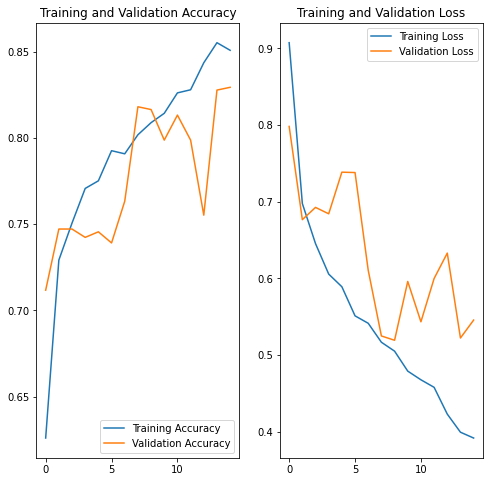

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Dapat dilihat bahwa data validation sudah lebih baik dibandingkan sebelumnya.


---

#### Percobaan prediksi dengan gambar yang berasal dari google.

1/1 [==============================] - 0s 57ms/step
This image most likely belongs to snowy with a 99.85 percent confidence.


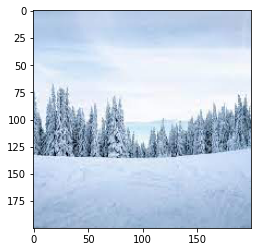

In [ ]:
# PERCOBAAN PREDIKSI GAMBAR KE-1
image_baru_url2 = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ27iw1QS79hlUJPtq60AraGyq94ZjSe0r78GzklRhE1APWIB21goAnGMxGpGLWAwAwh0k&usqp=CAU"

image_baru_path = tf.keras.utils.get_file('snowy', origin=image_baru_url2)
img = tf.keras.utils.load_img(
   image_baru_path, target_size=(img_height, img_width)
)
plt.imshow(img)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
 
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
 
print(
   "This image most likely belongs to {} with a {:.2f} percent confidence."
   .format(class_names[np.argmax(score)], 100 * np.max(score))
)


Dapat terlihat bahwa pada prediksi gambar pertama, model memberikan output yang diharapkan yaitu **snowy** dengan tingkat persentase yang tinggi yaitu **99.85%**.


---



1/1 [==============================] - 0s 19ms/step
This image most likely belongs to sunny with a 98.69 percent confidence.


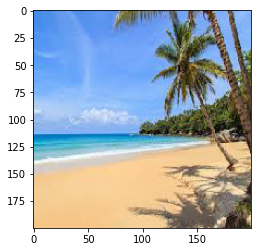

In [ ]:
# PERCOBAAN PREDIKSI GAMBAR KE-2
image_baru_url2 = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS3-Hb56RiaxXS58T7ypGKY2BMb6B5XF922GqgqmVpD1e8KdlNRrqpTAiAzQASgK0BvVEc&usqp=CAU"

image_baru_path = tf.keras.utils.get_file('sunny', origin=image_baru_url2)
img = tf.keras.utils.load_img(
   image_baru_path, target_size=(img_height, img_width)
)
plt.imshow(img)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
 
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
 
print(
   "This image most likely belongs to {} with a {:.2f} percent confidence."
   .format(class_names[np.argmax(score)], 100 * np.max(score))
)


Pada prediksi gambar kedua, model juga memberikan output yang diharapkan yaitu **sunny** dengan tingkat persentase yang tinggi yaitu **98.69%**.


---



1/1 [==============================] - 0s 21ms/step
This image most likely belongs to rainy with a 84.03 percent confidence.

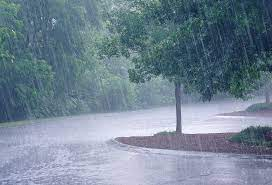

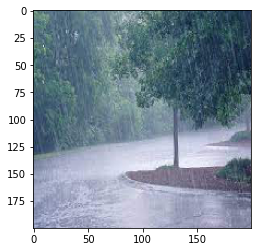

In [ ]:
# PERCOBAAN PREDIKSI GAMBAR KE-3
image_baru_url2 = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBcWFRgWFhYZGRgaGhwfHBwaGh4fHBwcGh4aHRweHBoeIS4lHB4rIRoeJjgmKy8xNTU1HCQ7QDs0Py40NTEBDAwMEA8QHhISHjQrISs0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NP/AABEIALkBEAMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAADBAECBQYAB//EAD8QAAEDAgMFBwMCBQIEBwAAAAEAAhEhMQNBUQQSYXGBBSKRobHB8DLR4RPxBhRCUoJykhUzYtIWNENTorLC/8QAGAEBAQEBAQAAAAAAAAAAAAAAAAECAwT/xAAeEQEBAQACAwEBAQAAAAAAAAAAARESIQIxQVFhcf/aAAwDAQACEQMRAD8AjEgiKcCKEfe6luzCD3jNwQJGpHK6VfBzIgzQfJU4TiC2s9c78/dbzPVePU4mHugS6ZuPl0u5piTWv2/KvjY0uOkketfnBCIqROU+E3XXx3O2kMeJ5+aq4mxvIrxIr7eK85hAHCeWX5V8W54wR1/KoPhvJTGFjHNKMJIGVET9SCJWbNDBxJNdT58OiuME8fTjRBcZrH7qcHEgwfNP8B8VhAqI/Khj7HoiveN3dINRTmPwUow3n589kncVpNAbBqP9OYNYRmPmABY56GonVKsxgGZGhvPoPlF7ZtrDaWMd0m1D40p4rA0Ns2QgkmTyNQdDneeKG/BFBR2pOmYgzXWtkodtMzmZk2mZsM6iNb80tgbVYAwdawCfmlJRdgmI2ZaxhrSQ2s3iYO7LZ480rtAeAHB9mxMERI3oMAHS/DRN4PajmiA1sf3xJqcxI85VMXFaW7zN5pEjvSRuxlkK+/CZanRZ23QDXdcA0i81qa5QYztFkNm3ghwMBpFRJIJN/OfFKl4mQTNaiWwTUfOKRxtocCHZQATe9IjpwpCvHWde2mN6hvb/AExSudlIfJ3wIm82Ft75wsg4rHEEkWF+Z1/qNqaIuyvaCWvJIIMRWuVTECbxxW8AMZ4DYpQiIOnKnU8FGM6BJ1ryvbrKHtALtbD0Qm4bnAjOBaugHqrIC4W1OJjQQOQki18kRgc9pNo70Rxyi+fhwWfgsLX3kC8ZHjPJaGzEl7mmda1J+SlKAwEzvAxefnH0V5EQGiGyAY1P3+aMO+kQR45G3MzKAYsKEtE1pFwIpNpvkpvaarimQIrqcgLU+T4Jd5n6vhN/NRiGWyDYkitvkFE3N4TxP39z4K/FeewACKyM+CVcZEgfOSYxcLuHVpt62EdF7DwoBmLA5fP3S0Cw3iQdIXg2p+SocO9b5c2VnvoDxI+y1K1HV4s5fJt5qjMQHuuoD+CM6RCM5osXEmJsMrfPRC/TLmkgTBFRcTIEi8SKmwMahc55SspdgR3t6aTapi+on7qCN5zYFXUnQ5KjcUhuh+/BWbBAg/j4VfHfpFXMjeaTZ2umh5FQ98gQAKNFBctBHnQlQ98OOZMeJp+FYNiGu7pBE8IP4WlaHZ+zsdvh7oiAwgiNRTOQLc6i4UeAKVMZ+iozaN0OAJ71KaCTXrHmpY+aHP7yhTDhQgcD6WUB9B68ghtdUZ0TDGZXrpkaKegbDdvAajjfLpkhvBBjzy+Qj7NgbpqCKR6fOiOcHeMuGWQ0MeazuKphM32mL6cqqH7IWs3wBvNP014ARSDNPEIuyMIMxY1HXzp6KnaLnNO/0pIIoCJrFws3d6C2JtMsq1sUiBFJNBFqwJ4pF+MAYGkZUzv8uj7S8hocCRIExwq2oiUtibm5bvH6QBNpma3+Zq9JVnkxwPvWPXLJCdiyIJiDSOPPKo4X6i3+6Kx66zxpKGwmb584BjLM18kxhc4ZLjM96p0IsZ8fVDGAAS0RvOtNpMRA1yninmAGCG1zpXKRT5VQWAmYym8RNcjzVtaZmzhzqOMbtBSgcJoQaTTmQCo/QLGkisTFNTAHE8eS1cFjZuWjSJobychVCxcxTO1qH9ldGO4mtL+Jm9tU3s2AA875B3rDLI55STwqjbUYDYAO8BMiI0nhX7JdkkEx3yIAjKCZB1yS+SWg4m4BRoLtRNTw1i9Qb9F7Hw4cw7wqJoDMmkX5fIQSIO7MVjx+BX2mXiTeJMWFBQCOnNJLqr4+G4fWYHOmvjQ+KQxcSDlG8RP5RMd+9XUZ8Es9v/yFuIofNXFwVrhaOPv6SjtcNwxmQeo9b/M0ySRPz5VMbJhmJpHiIznqQrZCw7szA7el0kg1PHXVKmhG6bGtfOMrK36hBBB/qqOdPC3igbS4b7gRrEf7qrMlSRDB3m04eP7qH4cAg36UiuVlZz5I3c/VTith5JgG8ReQJ4XnjRWVqOiG0briDUgmlwIiacZKNgbRuvoYbW+jhal7wlXADvGpdWeGiG2aRkSOg9MvBYnjLO2IOMQVa6oB404jopwx390/2z5/sh4ryCZr9lbZYLnFxqBA4mkTwotyY1BMMwSYpJHQW91QmXjIHXw9lMCDM1ExOc/b1VHUIEg7sRWaGecK/Ve/TN8vgXgruMQaR4ZeaoxlDrE/dNQXDNL2Pl8hOtNb0OfNIYLrg5iD5QmbAVB9b/kjop5DSZjkgV6cj5VJ8UyyoNaZzw+/sVnbJNZOfK9qpl1Ab2qCLDOQefBcqp1rwKzEigM/M0u7F3waSQAYI+oHIE8jxSrtqO6QRB4ATIOnRKDHMiAHFwNRMNFbgRNRlopNiabe9kFu6K1IORyvy8ysbaNp3t7nqZgCAPDx8Zc2UGuoFRMHUGKTXxhIY+yVcZy1B09L6rXj/S6puwAIkuIiQRQ2g2NyvYeHTvgiCDQCOPWYhewGud3YNqUpQH7Edc1ffe2roItIrEQY4E6H2WrqYb2Jv1BpcIm9jwGlT0S+K8gwb/MzxTbdo3mwGxPA3zPAJdmy/wBzrkxOtjBzy5G6zv6WIMm3jWhykqmM/doCHWBIPt0TWPtBYaAAN3Xagx4ZUpe6SfitdIeTSSI+okTHnUjiU9pnwvtLpkcZEnI1EnMmh/dB/Ug1qBmBTSYyoSp2p8xTd7uvE25IZZI3qwb9KHl+VueKrvjfoBVsiYgHPwM+Cjb3hkgMgkzJORqJpXNRj4w3RAqDXSlfM7yU2kbzWuzgtP8AiaSeRHgtYqm/I5H5XwVn4fdJ/sI8HCa9RHVeeyBFKjLoQepUMbJcKmdM8/bzRVHNjSJy8R6ouFiQCBB0nKfyIV24YNzGR+dPMJfFdJOQMz8srRcvJ07wvp8hU2upa7+4V59FH9NprxzEmtsj5LzmywCRIM35qL6Vc7dAg1GYNa9b0VP1Zjw9/UrzTIPESEuw3rGapHcu2eS0uFCNRnkYqBKSdhEF0ggV+0HjTyVmMO7QneabzleOV0fDedx3eqSAWmstg1GcggeS5TYxAA5paBHwW9URjC4bsgHnn7LzcK59D8+BXdg2LSZF5Glclq1NBeCHA3g19fuFBZ3iBXRN47G7rTMVNRXyVH7NTe35OYIjqPBXlGgWNkFvD0oUTBbYR+2aHgP70D5IVsOQRwP5CtFjhFp4hGfgkRofI6+Hvor79RW8fZFABEmZBuPnALPLPYJsbRe0AgjXl8zTeG8lwbH1TY1MZ9EmxhEkERIrY1iJHX1TWDjC+uWdNFzvYBtLd5+61vepxcYMGtYE/LpJ8sBDmkZd4RSa5cgaVpyWrj4AcRLz3RIECfHmOq87CBLSR9PWmUnOKQVZNXGTsodvS4EDi0tDifqrBjrSq8+WvcLAkCaGZiN0EcQfutf9BpiWilqWuDmmNowGvG64UpWK0PkfuhhNuytxQ1+5BzqBUUNgcxFRkdSs3btlLYH9IIiLzcQ6BN9PBaO3BzGhrPpFTGQynLPikNqxnuYN5pJIBraBeBkBVNLQWthsie6QYBuDPlbJB2h53qGACTNiJ8qmFU7QQ5wmJpTObQcx90u58xN47vOk2zlMtZQSC0yZE0Os6oDnAVjXMzpU9EUsAECwH1ajlHyUBxjvUItzn3utwBxMQOEZ6ZZammqs0HdI0qIOse6NuN3SRPSIFxM51+FC/VuNRnM5rQCxpgg8CM7ZeBR9kdLSIFINc4oa2GV0uCQbUjpprf8ACZeNx26LEW5giaX5ooO1YYaSwTIJknxpPK6FhGrdR6TH2Rd1wIOgra4NusC2qq3CDSJuetxFucqqsKNEt59RRKPFP+mTSZoap3aXTrEFxH9UXqNb21SgAoINeN/aymkewBLHC9JjkZ+/iqgb0Bt+dupR9noTNO9BHMT+OvFBw8EyQKxPH6ameg8FNF8DZ91xa6REjI3Ij1yQzsoa9w3jInnNLUOc+q1W7BvMBbAdpOcTNc7+Kps+BvOLiYeDcitKH0PkpaafZiX4+s091Ix6jz6IJBpNL8l51BByJ81cjJ52JXu9RoqMeaTwrx4+aVa/ifyLe6JvSfOMp59SpxTDRIDLeFZzztkrs2nu26RWkZaeSDgEVBFvMHTw81f9QCYJBHpyI4eazYYjad2WlgiRUqBcu6pkPhndmdKWrl7oOG2fRa8b00l47sg2p88EbZtDmKpYOy4BMYBIB8jpMp5ekMsbvmBx8j53RsHCO9BEVA0r+VXZ3Rak5+fqjOJkRfKFhcMsiK38x5KjqEmCA4zQzUZHVRuzQCSRlUi2WdT5FXYyRBbTjlAtqp6UPfGlft+Uwx7S2kilZsfsqt2YCsjSDMeKrgM3TFeXtNlqWVSz+0GFsCQXAtBNpiQaVzHFZn0GHO3iaAVgVJdvTUzSgQduO69wsN+0iIBnKlsslLNqkyIBtvWkG5LrTAFYzKkZDdh7hlwAMGQ4EHOrQeuRskdpcA7ea2AOMkcddCea3X4DQ4Ncwue913TFY8PqmRanJXf2AHuE91tKSCJ0GYpz/pWtwxzbhSgNongPwQq4zfppEU52+63u0OzO8WsEAAGlbQInlX5XN/kAZ3nTui0GwyoKZq6mE8Andg29JkQPmaq3Ah0lwBF5zrYTeSYiL8kd+zf2kXFzpXLqq7XhSROmXkByqeqsFGBpJ7xETpaJgDXTp0h0OAirqACk0kCvUK38u4NEzFABlIvS+h8slVmJAc29qxbprbwSKrivcQNCZEW/Jn2U/oGJvBubaZdD1QRvOcSDa9a3nwNUw/aDBbuwKyNaHdrpPmFQvjPiIzFRwJn38gkmF0WMVPt+EVhJdfPPjOaNtIIoJBHhJ+rPis7gthd53dArUTESCM87KMJ7axQmCdIBiOAiCr7G0wDu2NcgIgnkaH5Cvjs7x3BSZEWrUDjmsXRGI57x3WuO73ZAMu0tqRKUx94APG9JEW1mIMaDzW12ewy6aCGkdBocqFOtbvUNRlQcxP8AlY5RkrL9WMwvMlpz+UUOOZ6oZyKnEdBBHPy/ddsTDmHgggwfJQW7skzHzPIqcDEJhwvFRqMuqs/GqYGlPnNY2ooD3/8AUJ6/uEw8d6ljX7qThghsGoOlsxHn4BEEGnAxHGvVTlsN1DjpaLcQVTeGWlPVEDRu71QZr1oRwv5ILWzySelGivMIuCynGfnzgqEREkZx5EckUPEkCBpBnP7K1RGYmVkXDxDTy+dEGKkHzEeanBoYn3UkGlhYjRunQ+TgpxHzXznLMQAly6ARSvta6HiYmmaznYcY+DMUVmYsOj58qkN4wK+fmrucZafki6YYaxez2PO+ZBrUG37+NVnt7NYGlpLrzShrTSIiOvNabXS0i3WvyiA94yEajip4i2HhtG6RcCJz0ujNfEWiPBKsqRWqMNd2VqxVsQuNZz1r0WXtGyjdeQIca9Rp5p1sinVU2k9x+u6fQ2jkrhjC2XCLy6THdB66Jc4O80hpND+/MSB6LQ2AGCBmI+eKozAdNRcxflXzKtn4WYzcXAggindgamJM6TxKFgtqRI5m185sIM9FsP2SdCRHAHWYWRis3JaZ3jckZGZjy80jOKuxtx5NHUzqDBqZmvNAc+7vpqLWpnBt+UbZmlwgCSAQbW5HTurR/kBQgxIG8NSBT080vtWPs4O/ugAkmnQHKk24Zom2sIgj6iaeVwfDrKfGwboDhUzXpz/qPHVLPYZrQxSfGR5rHlupYM2xkXINRyBnh+FbCwQ2pJactDUQfAW43yVuz8MkbwJcXFzTnUmazYErRw9jdB3wCLGgMRGYFKJJVkpbDe47sCbjlEdRdPYTN2uc+c5/M17AwgKAZ510z5K7GySPhW8akc20yPT39kVrJZOYv5/lLYJgj5eyKCWzC3WRcAR7elD18kZ4qHEzbrf3SYefcDlb0TuHhywgGYqOv5WbEwTCdBItFRn8FfNNYbgWxGc/kJVjCRJi0X9UxhZZA0rFD9vC6yRYskRxy8uWfmvblKX+9UNtDWhF715JjAfMDnSOqKLg4W8B6G1MvBS3CYILQRWCNOEeY5dBG/ui2dDrmqvxCYprXM6Ap2Lv2aO9MyM6c6K0QRX0P5RsE0+41S+KyDFwntVsVm7891SaVyPrZWgkRwUBhrS4+e6sVGG6ngmh9Mi4KFgYJ0TTMIyYBrRKizDn6X4xxQXg5C56/nmmMDZ317pPT1hHOwuMwI6+ykmGETINeaPhuTTOzXG4Hij4fZnyFauEC/jSbWPNUxLRQzINNeK2W9kjirDswTZTF4uK7PZU8h1rC0mYczT5VT/DOAHPc05M9C0LpmdnBa1ccm/BdkKx8lZ+N2S5zoygVnoev3Xe/wDDwpGwBE4uG2HspzQZiST4WHoCmx2cSux/kwqP2WtkXHLt7N4eqs7sVriCW9NQLA1tUrphgcFO60TJAjUgRzlS4vGOUZ2GWnuUEZzQ8OGafw+zQ3XK50n8eC0Np25jASCHHQGfgXN7Xtz3mXGdALeHRMjNkjX/AE2A1e0dRks5j2jFcZ7uvQe6znYjqQJ+QqhzjceCdrN/GAzPl6VHmivrBFitrC7KYLkmOI9k2zs5gEbpPinOfjGOcYwrS2LB975hbLNlYKBgnomcLBsQAnK34vFhOwCKBszpllnlbzVxsLp7rTBuMumi6A4FdPnVHZs9kynFz7Oz3zOfHMaFMYfZrpmQKzmt5mzjgiNw4TKvFjf8LJmtDlx6lEw+yAP6lt7gRW4YTF4xks7Majjs1kTC0QxHYFFyM5nZzP7QiM2Fo/ob86LRaxF/TRcZzdkFt0eCuNl4LQ3eCkMTTCbNkRBso+FNfp9V79OP2TVwuNnHBWGGEYtqvDl88UMD3RqvBo+BEaDavgVYYZN56D7ojh/4VbG0vH/S8eD2/ZdlAXH/AMKCdqfGe/H+6fZdyMAlLQuWifwp3Ez+jwHl9lV+zzeOspq4UcRqB5oOJs4Nf1nDkwexT/8ALDh4H3VXYI4eCarJf2cI/wDMOP8Aif8AuS7ux2/+6D/gfutlzBr5Jd+GPgQYr+xwIIxGn/Ej3QH9kj+5vmtx7ABMgASeX2Wa/tLC39zfE+XQxBV1nSDuyptCoezToE9/xjBkjfaIiZoJOXMe4Q2dr4LiQHt8RrGabF5MtjOHzJGwW8E1+mMiCjMgaa+C0wXazh+4TLGHTkrtAg8PymWP+n4EUI4efsisw+BkIsSLK0RQBRQ91XaxEDheBCuHCiCjGK7cPNS3FAXjij4VkW3EZuHxQWYwRGYw0QHaxEaxLjaBRK7T2nuyGivFBqhquGBcptnaGK8dx5bA+kGDxO8L+Pisd/aOOxxDsTEaeL3D3Uak19F/TByU7jdPnwr5k/anuMue4mblx+6GMd/97vvyqouPqLgBJjyWT2j2/hYRLaueDBaBbStvBcA55pUnn4LwplFEOLpnfxi7eEYYAzqZI5xRVxP4ueDDcMAyYkyIyEUXMEmJ6+iu90wbUTE4/wBN/wAObU3Axg987u66YvUXuu2/8S7NYvI/wf7BfPCY8fnzioxMjGnlQqrj6D/4n2bJ5PJjv/0AoP8AFOzf3O/2lcBh0MRH5ofRLxlOvv8AOiYuR9Bd/Fmz6P8A9rf+75KA/wDi7ByZieDAP/v8hcLiOmlfyIohtfpJHM28kwyO1xf4tZkx8cwPn5CU2j+LGAfQ6f8AUFyWPiloBEHLiIpnQlZuM90TVO2PK2eo1e1u2cXGnvQ0k91sxBpU6R6lZHe3Jmo/b0VpMSd4SJtN6G9qhSC0gje4ipzppqjl39I4uK4kiZJ45/uq4GIaEze1qDj8ujtwASIMyRHAx+EDG2VzXEggAGZnjwV2NeOfX05mDmi4WA0CDXrVWaJ0Xt4DMXstqIwgTQeB8JUnHcL8KUqlxjiOvEdVDsQugHxQMNx3TExYphuLGQHr6pFj4IjiiPxPZQGbJrOuWSI1jomhyysgNxROkWAOfXmn2CAL8p14opHGwy0cM/Gtc1VoJ/aqbfiQACASTlaRxKC4VE86HX2ogs0wfZGwmmDpxKAwt/6Z4ybI/wDMd2K9ICyLOZOY1yy4quIwGM8vgUseNJrcorHisR0/ZAq/ZJtUaWQTsRFy8jSJHkFqA80VrE0YGJ2ew3a0TkARH+018FQdhMNQ93+JmnIiviujxH3FDrI+SkXmswOgj0SNMU9gAmG4saB2GRxvn6qjv4cxIo9nWR7LZLBcCDnW68500lwpk4/dXE1z7+wMbLc/3GPAgKj+yMYCrJvYtz6rog4im87yNuih+MRn4hMNrln9n4sfQRfKUu7Z3j+hw6HiusdtbhNASgYm1HNlaa6c6phrlC0tMljgRwPzJV2h1TevA5iV1D8bP9PzKu54gEsPKRbimLycg3EETWRUoLyASK86ea7Esa6m4OsFUdsLK9xvC05ZkaphycY54y+fj7LxxJBEg8qH0j911GN2e2RusHMx7JTE7Ki7WxwmPIhMOTnHuBilOlJAB+ckIEAWHOsgDSsDLiuhOwYcVBB/0vNxGmiUf2a0zDZ6GdExNjKBaAYaAAQc7m+fwIG04bCKOM2IAEcKnh6rSbscn/lvtA0MRo3h5oWPsrABvMe0mL73/ZwU4nTt37TuxEE311uhB++etIul2tgiY4/smtnwiRIgitLHz9yujDzMO/zRXc+sG2U0Vv0yALilZI9RkjYWGG2BdlIJpOnLVFUdhD+4CBr8rOSLuBw7skgxSgGpIIp+V44LQKtkmwBNeaZGGSBLY0GniIHQqKDvNbumASTQ8qUH7JhuPUEtIpeuXMCnGyq3ENaUygX8KlXbi0+sNngJ8PwoPYeK5zvpEcQCfVQMECpY6+nsqfrgmr7WAnzg/IVg7eiHO6E20qgMxgmjCOJA+9VLsJ2QaFLMIzMmDqT8KKXEXcAON/NZC+HspM1b0qmWYUf1dF7DdoQRyFSrCf2hBIaAvcl4gBeMH5KNIcgvFUZwQ3BAvSeqG54RnNGcIRYNPnJGUgyg7R18UTei3y6BjPJ0QLudemaq95noqOYJPFQR4wtC7HmPuiF5iOqXBhE/VaP6hlYjrndAbAk3TYZy+dUiypoO7ll5FHDJv6jwQWx8H5Ky9sBBpOt1ovYYsR0H3lJ47SgycVx18/wgnEM0kGlZzWs9g3R6c8wky0UkeSDPGI8G5oeMeaL/ADbwIkkARUTC0mYbSLCZzGSqIAgAReyBn9QRvhkiDUvAtwRmbUaEgWtWB4hZ+L9DF7Yb9PcLbLSbtEiQ18zJLpA6Zq7MVzjQCQR9W8ZHUn5Ct/6Xh6IOwf8AMdz+6ir4m1OB3Z3a2J5Whtuqph4lK7zp4e9SVsjLmVnbRlyHqopd8mIbap4A6m682atgUGgnwF88ygN+l3zVWZcdUBzi1ABgxkMuSKYqYaBOsO83JXHsOX2U4n0Dn91BoMxKE18RSsXrRE/UIsRx3RbnCUZY8vdQPo6+yDQY92bm+U+Eo8znzok2/SPmahluoWRoNPJXPNKYXv7o+Hb5qjS0KjpV0LE+vw90AXt/bNCc+BXzRsZJvy5eysZEdjgX/PqgY2KCbFRhKzvb2VCZmbDmSibtIPkYUuz6KmJc80Hu6MvNSHCBB+fCh7RcdFQ2HzRA4MQDKT8sjMxW5jnB9FnfcKX+6NNF+Iz3ukcR7Tb1r5qpsgvsOYQWeKmDkTWn7pGKXrKby6JZv1dEZewzGakYmQrBv9yoZ9Pj6KG2HzRB/9k="

image_baru_path = tf.keras.utils.get_file('rainy50', origin=image_baru_url2)
img = tf.keras.utils.load_img(
   image_baru_path, target_size=(img_height, img_width)
)
plt.imshow(img)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
 
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
 
print(
   "This image most likely belongs to {} with a {:.2f} percent confidence."
   .format(class_names[np.argmax(score)], 100 * np.max(score))
)



Pada prediksi gambar ketiga, model memberikan output yang diharapkan yaitu **rainy** dengan tingkat persentase yang tinggi yaitu **84.03%**, walaupun tidak setinggi ketika prediksi gambar pertama dan kedua.


---



1/1 [==============================] - 0s 40ms/step
This image most likely belongs to foggy with a 99.12 percent confidence.


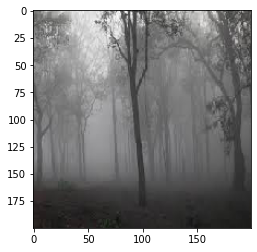

In [ ]:
# PERCOBAAN PREDIKSI GAMBAR KE-4
image_baru_url2 = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRpX7T5XbJ4CZEcVeELTaOTjJM7BJSz4FJrEg&usqp=CAU"

image_baru_path = tf.keras.utils.get_file('foggy', origin=image_baru_url2)
img = tf.keras.utils.load_img(
   image_baru_path, target_size=(img_height, img_width)
)
plt.imshow(img)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
 
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
 
print(
   "This image most likely belongs to {} with a {:.2f} percent confidence."
   .format(class_names[np.argmax(score)], 100 * np.max(score))
)


Pada prediksi gambar keempat, model juga memberikan output yang diharapkan yaitu **foggy** dengan tingkat persentase yang tinggi, mencapai **99.12%**.


---



#### Mencoba menggunakan data test untuk melihat akurasi pada model yang telah dibuat.
#### Terlihat bahwa akurasi model untuk memprediksi lumayan tinggi yaitu dengan **akurasi 0.8344** dengan tingkat **loss 0.4548**

In [ ]:
prediksi = model.evaluate(
    test_ds,
    batch_size=batch_size
)

20/20 [==============================] - 1s 45ms/step - loss: 0.4548 - accuracy: 0.8344
